In [10]:
### IMPORTS ###
%load_ext autoreload
%autoreload 2
import sys, os
import pandas as pd
from pathlib import Path


# insert the project root (one level up from this folder) onto sys.path
ROOT = Path(os.getcwd()).parent.resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# now imports will work
from src.utils.visualization import plot_metrics, visualize_slices
from src.utils.file_io       import load_history


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
EXPERIMENT = "exp25_nnunet"
BASE_DIR = Path("../results") / EXPERIMENT
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
MODEL_DIR = BASE_DIR / "models"
LOG_DIR = BASE_DIR / "logs"
PRED_DIR         = BASE_DIR / "predictions"

[fold0] Loading history from ../results/exp25_nnunet/fold0/logs/history_086.json


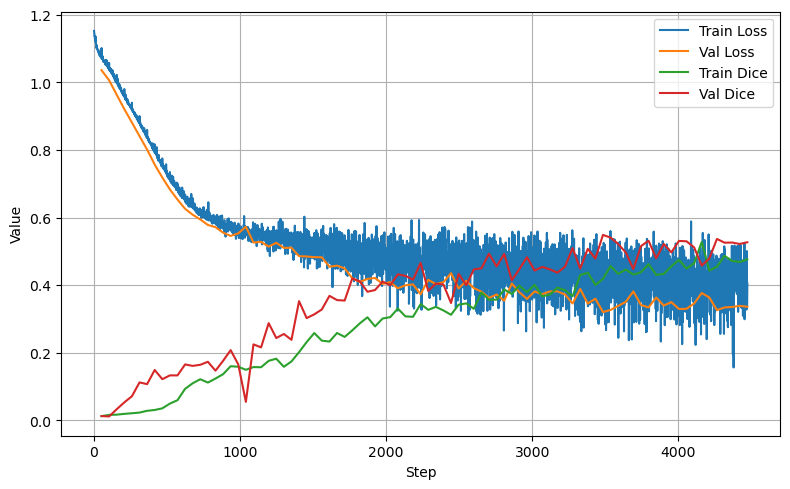


Fold 0 final metrics @ step 4472.0:
  Train Loss = 0.405, Val Loss = 0.336
  Train Dice = 0.476, Val Dice = 0.527
  Train Class1 Dice = 0.429, Val Class1 Dice = 0.470
  Train Class2 Dice = 0.524, Val Class2 Dice = 0.584

Fold 0 best metrics @ step 3484.0:
  Train Loss = 0.427, Val Loss = 0.320
  Train Dice = 0.419, Val Dice = 0.549
  Train Class1 Dice = 0.368, Val Class1 Dice = 0.483
  Train Class2 Dice = 0.470, Val Class2 Dice = 0.614
[fold1] Loading history from ../results/exp25_nnunet/fold1/logs/history_168.json


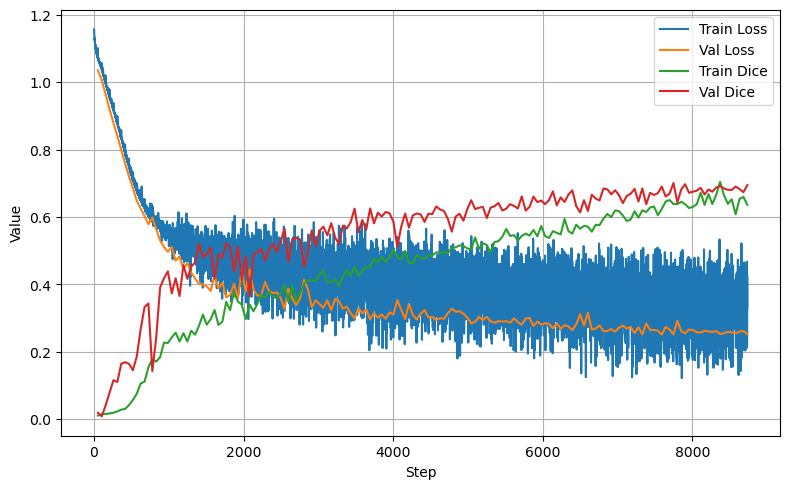


Fold 1 final metrics @ step 8736.0:
  Train Loss = 0.331, Val Loss = 0.253
  Train Dice = 0.636, Val Dice = 0.695
  Train Class1 Dice = 0.574, Val Class1 Dice = 0.635
  Train Class2 Dice = 0.698, Val Class2 Dice = 0.755

Fold 1 best metrics @ step 7748.0:
  Train Loss = 0.324, Val Loss = 0.252
  Train Dice = 0.639, Val Dice = 0.701
  Train Class1 Dice = 0.575, Val Class1 Dice = 0.642
  Train Class2 Dice = 0.703, Val Class2 Dice = 0.761
[fold2] Loading history from ../results/exp25_nnunet/fold2/logs/history_080.json


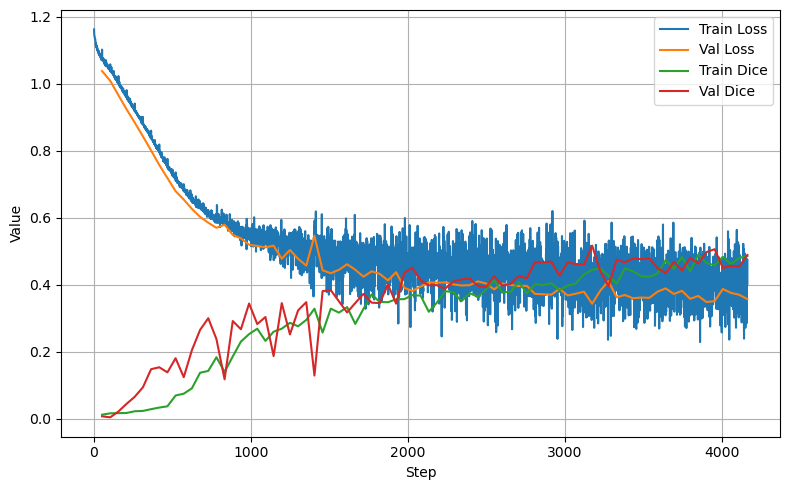


Fold 2 final metrics @ step 4160.0:
  Train Loss = 0.400, Val Loss = 0.357
  Train Dice = 0.486, Val Dice = 0.489
  Train Class1 Dice = 0.447, Val Class1 Dice = 0.338
  Train Class2 Dice = 0.525, Val Class2 Dice = 0.640

Fold 2 best metrics @ step 3172.0:
  Train Loss = 0.421, Val Loss = 0.344
  Train Dice = 0.445, Val Dice = 0.517
  Train Class1 Dice = 0.439, Val Class1 Dice = 0.358
  Train Class2 Dice = 0.451, Val Class2 Dice = 0.676
[fold3] Loading history from ../results/exp25_nnunet/fold3/logs/history_116.json


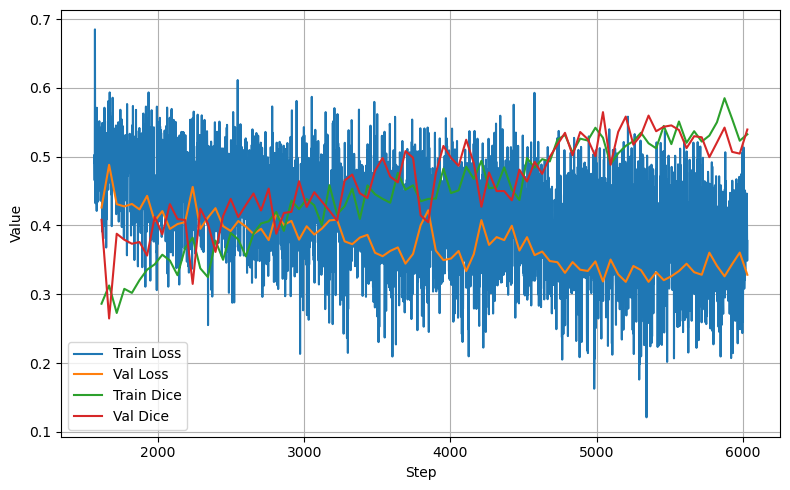


Fold 3 final metrics @ step 6032.0:
  Train Loss = 0.378, Val Loss = 0.328
  Train Dice = 0.533, Val Dice = 0.539
  Train Class1 Dice = 0.465, Val Class1 Dice = 0.498
  Train Class2 Dice = 0.600, Val Class2 Dice = 0.581

Fold 3 best metrics @ step 5044.0:
  Train Loss = 0.382, Val Loss = 0.319
  Train Dice = 0.528, Val Dice = 0.565
  Train Class1 Dice = 0.480, Val Class1 Dice = 0.512
  Train Class2 Dice = 0.575, Val Class2 Dice = 0.618
[fold4] Loading history from ../results/exp25_nnunet/fold4/logs/history_111.json


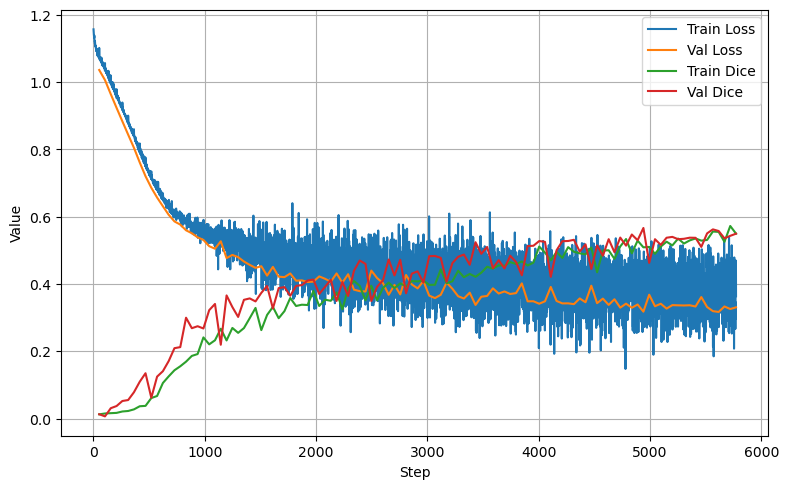


Fold 4 final metrics @ step 5772.0:
  Train Loss = 0.364, Val Loss = 0.331
  Train Dice = 0.550, Val Dice = 0.550
  Train Class1 Dice = 0.487, Val Class1 Dice = 0.531
  Train Class2 Dice = 0.613, Val Class2 Dice = 0.569

Fold 4 best metrics @ step 4940.0:
  Train Loss = 0.386, Val Loss = 0.318
  Train Dice = 0.509, Val Dice = 0.567
  Train Class1 Dice = 0.445, Val Class1 Dice = 0.545
  Train Class2 Dice = 0.574, Val Class2 Dice = 0.588

5-fold mean validation Dice: 0.560


In [12]:
# 1) Discover existing fold directories
fold_dirs = sorted(
    [d for d in BASE_DIR.iterdir() if d.is_dir() and d.name.startswith("fold")],
    key=lambda p: int(p.name.replace("fold", ""))
)

all_final_dice = []

for fold_dir in fold_dirs:
    fold_idx = int(fold_dir.name.replace("fold", ""))
    log_dir = fold_dir / "logs"

    if not log_dir.exists():
        print(f"Skipping fold{fold_idx}: no logs directory found.")
        continue

    # 2) Locate and load the latest history JSON
    history_files = sorted(
        log_dir.glob("history_*.json"),
        key=lambda p: int(p.stem.split("_")[-1])
    )
    if not history_files:
        print(f"Skipping fold{fold_idx}: no history_*.json files.")
        continue

    latest_history = history_files[-1]
    print(f"[fold{fold_idx}] Loading history from {latest_history}")
    history = load_history(str(latest_history))

    # 3) Plot training and validation metrics for this fold
    plot_metrics(
        history,
        metrics=[
            ("train",      "loss", "Train Loss",  None),
            ("validation", "loss", "Val Loss",    None),
            ("train",      "dice", "Train Dice",  None),
            ("validation", "dice", "Val Dice",    None),
        ]
    )

    # 4) Extract per-step records into a DataFrame
    records = []
    for step_str in history["validation"]["dice"]:
        records.append({
            "step": int(step_str),
            "train_loss":       history["train"]["loss"].get(step_str),
            "val_loss":         history["validation"]["loss"].get(step_str),
            "train_dice":       history["train"]["dice"].get(step_str),
            "val_dice":         history["validation"]["dice"].get(step_str),
            "train_dice_class1": history["train"].get("dice_class1", {}).get(step_str),
            "val_dice_class1":   history["validation"].get("dice_class1", {}).get(step_str),
            "train_dice_class2": history["train"].get("dice_class2", {}).get(step_str),
            "val_dice_class2":   history["validation"].get("dice_class2", {}).get(step_str),
        })
    df = pd.DataFrame(records).sort_values("step")

    # 5) Print final metrics at last step
    final = df.iloc[-1]
    print(f"\nFold {fold_idx} final metrics @ step {final.step}:")
    print(
        f"  Train Loss = {final.train_loss:.3f}, Val Loss = {final.val_loss:.3f}\n"
        f"  Train Dice = {final.train_dice:.3f}, Val Dice = {final.val_dice:.3f}\n"
        f"  Train Class1 Dice = {final.train_dice_class1:.3f}, Val Class1 Dice = {final.val_dice_class1:.3f}\n"
        f"  Train Class2 Dice = {final.train_dice_class2:.3f}, Val Class2 Dice = {final.val_dice_class2:.3f}"
    )

    # 6) Print metrics at the best validation Dice step
    best_idx = df["val_dice"].idxmax()
    best = df.loc[best_idx]
    print(f"\nFold {fold_idx} best metrics @ step {best.step}:")
    print(
        f"  Train Loss = {best.train_loss:.3f}, Val Loss = {best.val_loss:.3f}\n"
        f"  Train Dice = {best.train_dice:.3f}, Val Dice = {best.val_dice:.3f}\n"
        f"  Train Class1 Dice = {best.train_dice_class1:.3f}, Val Class1 Dice = {best.val_dice_class1:.3f}\n"
        f"  Train Class2 Dice = {best.train_dice_class2:.3f}, Val Class2 Dice = {best.val_dice_class2:.3f}"
    )

    all_final_dice.append(float(final.val_dice))

# 7) Cross-fold summary
if all_final_dice:
    mean_dice = pd.Series(all_final_dice).mean()
    print(f"\n{len(all_final_dice)}-fold mean validation Dice: {mean_dice:.3f}")
else:
    print("No valid folds were processed; no summary to display.")




Label class distribution: (1713121, 30645, 25706)
Prediction class distribution: (1721647, 23907, 23918)


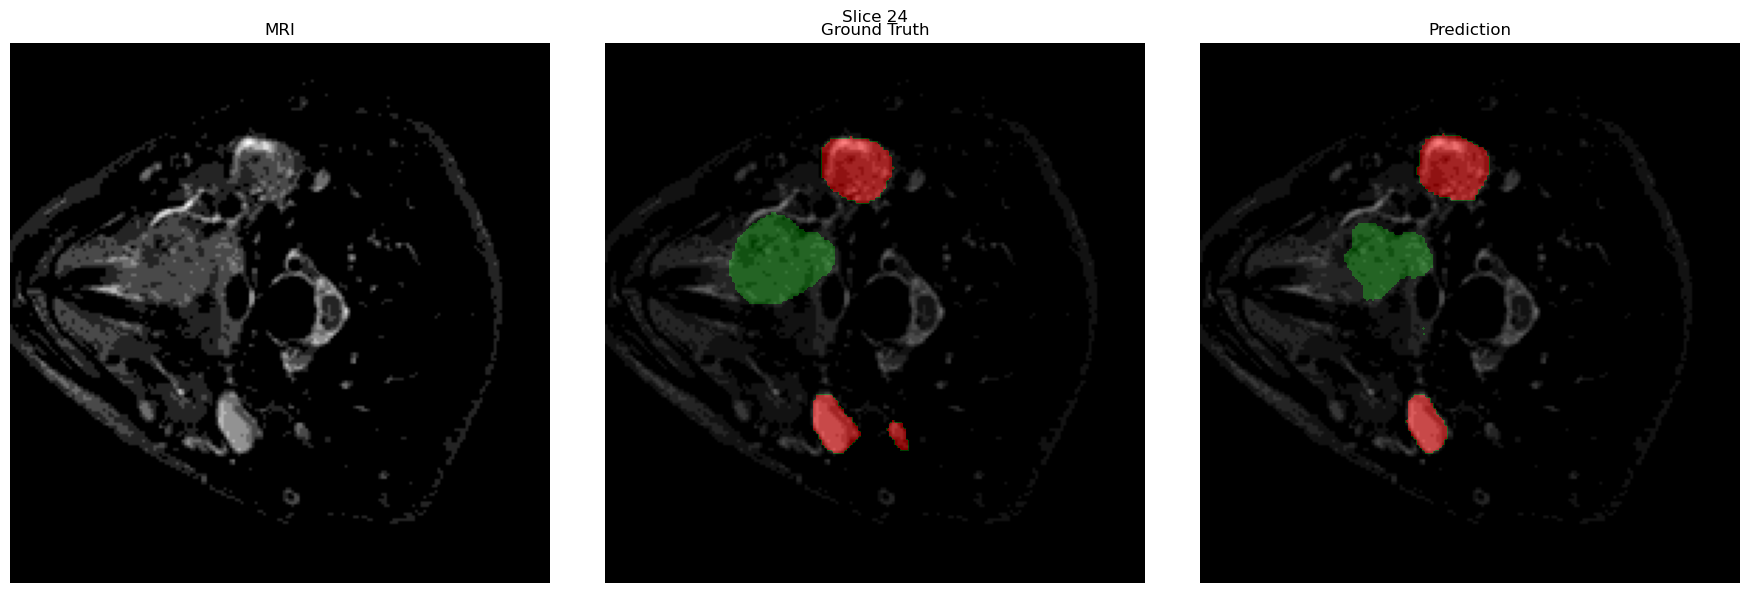

In [23]:
### VISUALIZATION ###
exp = "exp25_nnunet"
fold = "fold1"
preds = ROOT / "results" / exp / fold / "predictions"

image_path      = preds / "image_1.nii.gz"
label_path      = preds / "label_1.nii.gz"
prediction_path = preds / "prediction_1.nii.gz"

visualize_slices(str(image_path), str(label_path), str(prediction_path), slice_idx=24)
